In [43]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import csv

Pre-processing for Images: (Not all steps always needed)
1. Crop and re-sample to single size (e.g., 1000 × 800 pixels)
2. Down-sample to smaller size (for less computations)
3. Noise filtering (Gaussian blur)
4. Correct lighting (histogram normalization) -> need to try
5. Color to Gray-scale (needed by some feature extractors)

(Slide Ref: FeatureExtraction_ManualMethods page 18)

In [44]:
def preprocess_image(image_path, target_size=(1000, 800)):
    # Load the image
    image = cv2.imread(image_path)
    
    # Crop and re-sample to single size (e.g., 1000 × 800 pixels)
    image = cv2.resize(image, target_size)
    
    # Color to Gray-scale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Noise filtering (Gaussian blur)
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
    
    return blurred_image

In [45]:
def compute_gradients(image):
    # Compute gradients in X and Y directions using Sobel operator
    grad_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    
    # Compute magnitude and angle
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    angle = np.arctan2(grad_y, grad_x) * (180 / np.pi)  # Convert to degrees
    
    # Normalize the angle to be in the range [0, 180)
    angle = np.mod(angle, 180)
    
    return magnitude, angle

In [46]:
def compute_hog(image, cell_size=(8, 8), block_size=(2, 2), orientations=9):
    # Compute gradients (magnitude and orientation)
    magnitude, angle = compute_gradients(image)
    
    # Image dimensions
    height, width = image.shape
    
    # Number of cells (height, width) in the image
    num_cells_y = height // cell_size[1]
    num_cells_x = width // cell_size[0]
    
    # Initialize the feature vector
    hog_features = []
    
    # Loop over each cell and calculate the histogram
    for i in range(num_cells_y):
        for j in range(num_cells_x):
            # Get the region for this cell
            cell_magnitude = magnitude[i * cell_size[1]:(i + 1) * cell_size[1], 
                                       j * cell_size[0]:(j + 1) * cell_size[0]]
            cell_angle = angle[i * cell_size[1]:(i + 1) * cell_size[1], 
                               j * cell_size[0]:(j + 1) * cell_size[0]]
            
             # Flatten the magnitude and angle to align their shapes -> error in shape size
            cell_magnitude_flattened = cell_magnitude.flatten()
            cell_angle_flattened = cell_angle.flatten()
            
            # Create a histogram of gradient directions for this cell
            hist, _ = np.histogram(cell_angle_flattened, bins=orientations, range=(0, 180), weights=cell_magnitude_flattened)
            hog_features.extend(hist)
    
    # Normalize the histograms across blocks (optional)
    # Reshape to get a block of cells, then normalize them
    hog_features = np.array(hog_features)
    
    return hog_features
    


In [54]:
def process_car_image(image_path):
    # Preprocess the car image
    preprocessed_image = preprocess_image(image_path)
    
    # Extract HOG features from the preprocessed image
    hog_features = compute_hog(preprocessed_image)
    hog_image_rescaled = np.reshape(hog_features, (preprocessed_image.shape[0] // 8, preprocessed_image.shape[1] // 8, 9))
    
    # # Visualize the preprocessed image and HOG features
    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
    
    # ax1.axis('off')
    # ax1.imshow(preprocessed_image, cmap='gray')
    # ax1.set_title('Input Image')
    
    # # Convert the feature vector into a visualization (optional)
    # ax2.axis('off')
    # ax2.imshow(np.sum(hog_image_rescaled, axis=2), cmap='gray')
    # ax2.set_title('Histogram of Oriented Gradients')
    
    # plt.show()
    # Visualize the HOG features
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(preprocessed_image, cmap='gray')
    plt.axis('off')

    # Display the HOG features visualization
    plt.subplot(1, 2, 2)
    plt.imshow(np.sum(hog_image_rescaled, axis=2), cmap='gray')
    plt.title(f'HOG Features')
    plt.axis('off')
                
    plt.show()
    
    return hog_features

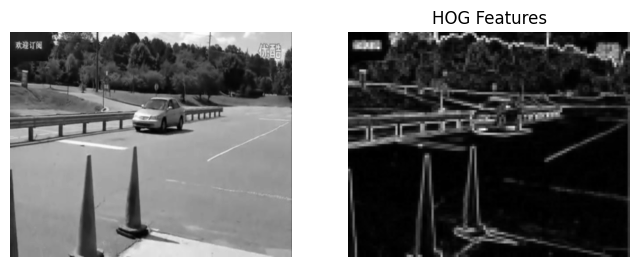

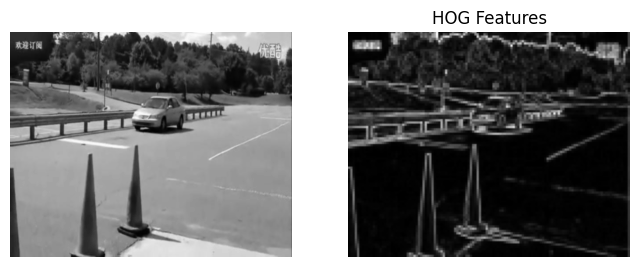

array([  0.        ,   0.        ,   0.        , ...,   0.        ,
         0.        , 504.66061893])

In [49]:
image_path_1 = 'dataset/car/car-test/00000001.jpg'
image_path_2 = "dataset/car/car-test/00000002.jpg"
process_car_image(image_path_1)
process_car_image(image_path_2)


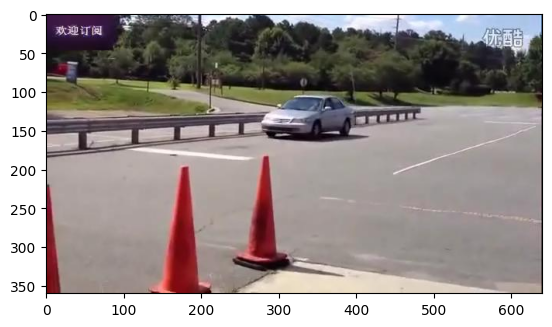

In [ ]:
image = cv2.imread(image_path_1)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Display the image using matplotlib
plt.imshow(image_rgb)

In [41]:
 preprocessed_image = preprocess_image(image_path_1)

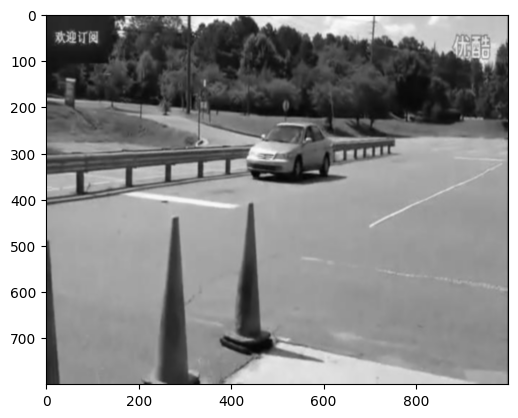

In [42]:
image_rgb = cv2.cvtColor(preprocessed_image, cv2.COLOR_BGR2RGB)
# Display the image using matplotlib
plt.imshow(image_rgb)

In [ ]:
# Function to process and visualize images in the folder
def process_images_in_folder(input_folder, output_folder, csv_file):
    os.makedirs(output_folder, exist_ok=True)
    os.makedirs(os.path.dirname(csv_file), exist_ok=True)
    
    with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Image_ID'] + [f'HOG_bin_{i+1}' for i in range(36)])  # Example header
        
        for image_name in os.listdir(input_folder):
            if image_name.endswith('.jpg') or image_name.endswith('.png'):
                image_path = os.path.join(input_folder, image_name)
                
                # Preprocess image
                preprocessed_image = preprocess_image(image_path)
                
                # Extract HOG features
                hog_features = compute_hog(preprocessed_image)
                hog_image_rescaled = np.reshape(hog_features, (preprocessed_image.shape[0] // 8, preprocessed_image.shape[1] // 8, 9))
                hog_image_2d = np.sum(hog_image_rescaled, axis=2)  # Sum along the 3rd dimension (orientations)
                hog_image_2d = cv2.normalize(hog_image_2d, None, 0, 255, cv2.NORM_MINMAX)
                hog_image_2d = np.uint8(hog_image_2d)
               
                # Save the preprocessed image in output folder
                output_image_path = os.path.join(output_folder, image_name)
                cv2.imwrite(output_image_path, hog_image_2d)
                
                # Write HOG features to CSV
                writer.writerow([image_name] + list(hog_features))
                
                # Visualize the HOG features
                plt.figure(figsize=(8, 4))
                plt.subplot(1, 2, 1)
                plt.imshow(preprocessed_image, cmap='gray')
                plt.title(f'Input Image: {image_name}')
                plt.axis('off')

                # Display the HOG features visualization
                plt.subplot(1, 2, 2)
                plt.imshow(np.sum(hog_image_rescaled, axis=2), cmap='gray')
                plt.title(f'HOG Features: {image_name}')
                plt.axis('off')
                
                plt.show()

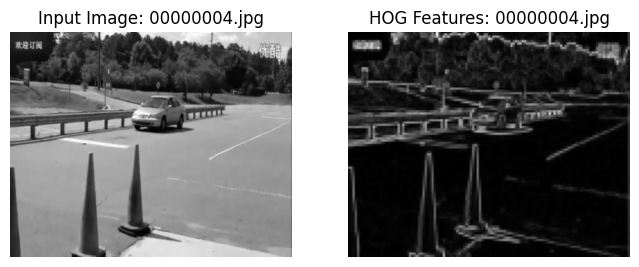

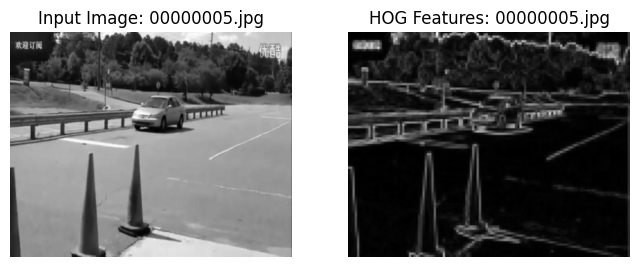

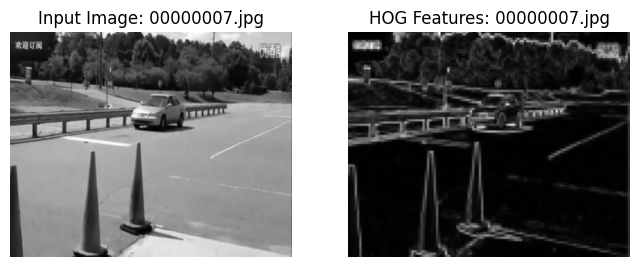

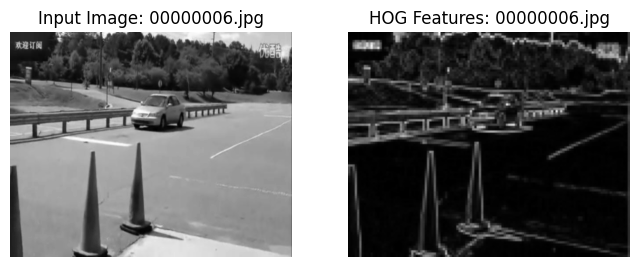

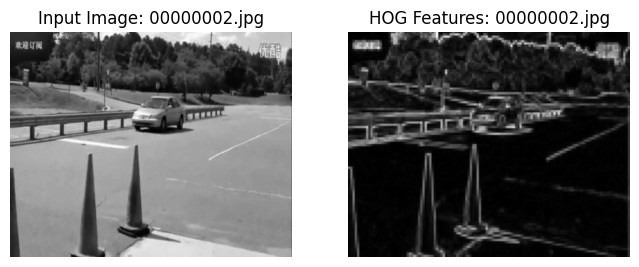

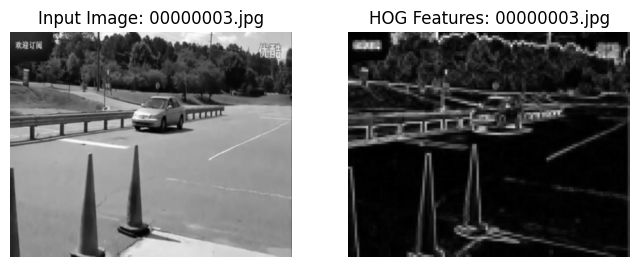

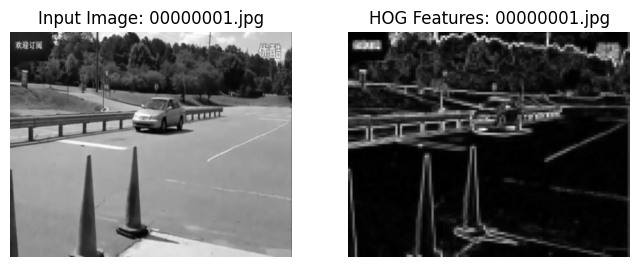

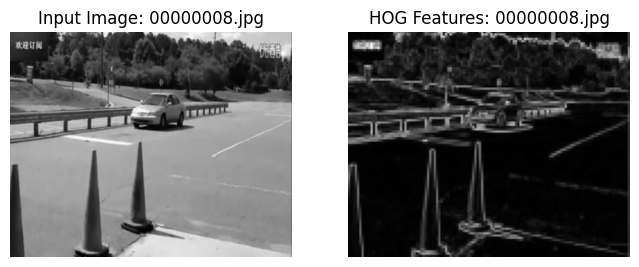

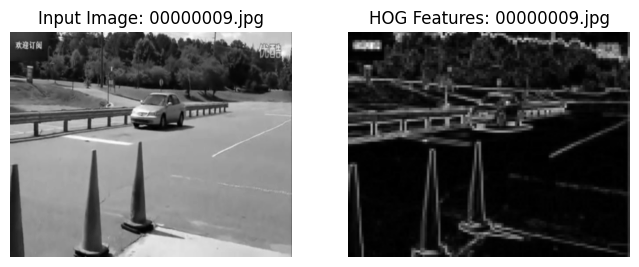

In [68]:
input_folder = 'dataset/car/car-test'  
output_folder = 'hogfeatures/car/car_test'  
csv_file = 'hogfeatures/car/car-test.csv' 

# Process all images in the folder
process_images_in_folder(input_folder, output_folder, csv_file)